{[Click here to read this notebook in GitHub](https://github.com/gsolaril/topCMC/blob/main/Main%20report.ipynb)}

<head><link rel = "stylesheet" href = "https://github.com/gsolaril/Templates4Coding/blob/master/Python/custom.css"></head>

<table class = "header"><tr>
    <th align = "left">Profluent recruitment test, 2022\04\12</th>
    <th align = "right">Written by: Gaston Solari Loudet</th>
</tr></table>

### <center>Performance analysis of top-50 market capitalization cryptocurrencies</center>

The objective of this notebook is to measure certain variables that may indicate the performance of those 50 cryptoassets which have the largest circulating value in terms of fiat currency. Special interest has been considered in calculating certain "alpha" metrics provided by Z. Kakushadze from "Quantigic Solutions LLC(R)" in the paper <a href = "https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf">from this link</a>.

This notebook is practically divided in two parts.
* The first part and its sections define an instrument **selection scheme based on the ranking of these alphas** applied to a large set of prefiltered cryptocurrencies from Binance.
* The second part calculates common backtesting, simulation and statistical metrics over the selection from the first part. This part intends to approach to a practical and straightforward backtesting report as much as possible.

#### Libraries and imports

The next code cell prepares the required functions and classes to be used in the rest of the document. There are two custom added features for this purpose:
* "**Appendix.py**" file, which holds the "`Alpha`" class with the individual static methods/calculators. Also all the needed "`Appendix`" time series common functions found in the appendix of the document itself.
* "**MyCMC.py**" file, which holds the "`MyCMC`" class which wraps up pretty much all of the features that are required to download and pre-process market data from the different APIs. *The code in this file is entirely commented for easy step-to-step comprehension.*
* "**Portfolio.py**" file, which holds the "`Portfolio`" class. It's a simple object with basic backtesting and forwardtesting (Monte Carlo) features: takes a set of log-return time series and certain allocation rules, and reconstructs the curve of how the instrument set would have performed in the past. More info later.

**Note:** The latter file needs authorization to retrieve data from APIs. "**config.ini**" text file takes care of this by storing auth tokens with the following structure:

>`[Binance]`<br>
`apiKey = `{64-character API key}<br>
`secret = `{64-character secret key}<br>
`password = `{Binance account password}<br>
`[CoinMarketCap]`<br>
`apiKey = `{36-character API key}<br>
`apiTest = b54bcf4d-1bca-4e8e-9a24-22ff2c3d462c`*<br>
<i>(*Provided by CMC for testing connectivity. Does not get any useful information)</i>

Please, create a fresh new file in the same folder as this notebook, and add your own keys to run the code. The GitHub repository will ignore it while pushing the commits, for security.

In [1]:
import numpy
from pandas import DataFrame, MultiIndex
from pandas import to_datetime as datetime
from pandas import concat, read_csv
from IPython.display import display as print
from scipy import stats
from src.Portfolio import *
from src.Appendix import *
from src.MyCMC import *

**Multi-index easy swapping**

The market <code>DataFrame</code>s provided by "<code>MyCMC</code>" will be multi-indexed. To be able to access data by price column or by ticker column in a fast way, the following "<code>swap</code>" function is provided. Inputs are the dataframe "<code>DF</code>" being swapped, and "<code>byOHLC</code>" which is "{ <code>True</code> | <code>False</code> }" in case we wish to select/extract data from a particular { **(lowercase) price** | **(uppercase) cryptocurrency** } column.

In [2]:
def swap(DF: DataFrame, byOHLC: bool):
    testColumn = DF.columns.levels[0][0]
    if byOHLC: f = lambda x: x.isupper()
    else: f = lambda x: x.islower()
    if f(testColumn): DF = DF.swaplevel(axis = "columns")
    return DF.sort_index(axis = "columns", level = 0)

<hr>

#### Downloading data

The next cell wraps up pretty much all functionalities of the "`MyCMC`" class:
* **(a)** Downloading market cap stats from with "`.requestCMC`". from CoinMarketCap.<br>
  **(b)** Or downloading daily volume stats from "`.requestDMV`" from Binance.
* Downloading OHLC candle data from the top market cap cryptocurrencies with "`.getBinance`".<br>
The amount of these that the function will keep as top, is given by the number "`keepTop`".

After some research, it has become evident that CCXT library through the **Binance** API does not have an endpoint to get the former; at least not in an easy, direct way. On the other hand, CoinMarketCap does. But it is not included as a CCXT feature, so it became simpler to briefly wrap its API requests.

As both "`.requestDMV`" and "`.getBinance`" use the same database, there shouldn't be any problem. However, the cryptocurrency tickers may not be named or labelled with the same denomination between CMC and Binance. Therefore, a particular mapping file ("**BCMapper.py**") was needed to go from one to the other.

Take notice that there may be still two error causes:
* The "`.requestCMC`" may warn of a "not-found" error if any ticker could not be mapped because of not being found in such file. Skipping or manual addition might be necessary in that case.
* The ticker may be present in the file, and Binance may recognise it, but it may not have any market data for that symbol. In that case, skipping or another third-party source may be the only solution. (e.g.: the ones that appear below)

**Note:** Most custom classes and methods have at least a signature description. If reading this on VSCode, **hover the mouse over the function names / executions** to read further information.

In [3]:
filename = "./csv/test OHLCV.csv"
if os.path.exists(filename):
    marketDF = read_csv(filename, index_col = 0, 
        parse_dates = True, header = [0, 1])
else: 
    myCMC = MyCMC()
    # uncomment THIS ↓ if wishing to keep the old pre-filter based on Market Capitalization
    # myCMC.requestCMC(keepTop = 70)
    # uncomment THIS ↓ if wishing to apply the new pre-filter based on Daily Mean Volume.
    myCMC.requestDMV(keepTop = 50, findMean = "onMonth")
    myCMC.getBinance(timeFrame = "4h", since = "2021-01-01")
    marketDF = myCMC.dataBinance.copy()
    marketDF.to_csv(filename)

quotes, columns = marketDF.columns.levels
print("Preview of OHLCV dataframe:", marketDF.iloc[[0, 1, 2, -2, -1]])

'Preview of OHLCV dataframe:'

VTHO                                        VET  \
                       open    high     low   close     volume    open   
time                                                                     
2021-01-01 01:00:00  0.0008  0.0008  0.0007  0.0007   350928.0  0.0193   
2021-01-01 02:00:00  0.0007  0.0008  0.0007  0.0008   584114.0  0.0199   
2021-01-01 03:00:00  0.0008  0.0008  0.0007  0.0007   202128.0  0.0199   
2022-04-22 00:00:00  0.0040  0.0041  0.0040  0.0041  1340924.0  0.0588   
2022-04-22 01:00:00  0.0040  0.0041  0.0040  0.0041  2986457.0  0.0589   

                                                         ...    POLY          \
                       high     low   close      volume  ...    open    high   
time                                                     ...                   
2021-01-01 01:00:00  0.0200  0.0192  0.0199  24259461.0  ...  0.4532  0.4532   
2021-01-01 02:00:00  0.0202  0.0195  0.0199  17748095.0  ...  0.4532  0.4532   
2021-01-01 03:00:00  0.0199  0.0196  0.0196   2229808.0  ...  0.4532  0.4532   
2022-04-22 00:00:00  0.0592  0.0582  0.0588   1822071.0  ...  0.4162  0.4176   
2022-04-22 01:00:00  0.0591  0.0588  0.0588    679839.0  ...  0.4178  0.4333   

                                               VOXEL                          \
                        low   close   volume    open    high     low   close   
time                                                                           
2021-01-01 01:00:00  0.4532  0.4532      0.0  1.6472  1.6472  1.6472  1.6472   
2021-01-01 02:00:00  0.4532  0.4532      0.0  1.6472  1.6472  1.6472  1.6472   
2021-01-01 03:00:00  0.4532  0.4532      0.0  1.6472  1.6472  1.6472  1.6472   
2022-04-22 00:00:00  0.4142  0.4164   4889.5  1.4051  1.4196  1.4025  1.4064   
2022-04-22 01:00:00  0.4178  0.4271  33903.7  1.4095  1.4133  1.4070  1.4082   

                             
                     volume  
time                         
2021-01-01 01:00:00     0.0  
2021-01-01 02:00:00     0.0  
2021-01-01 03:00:00     0.0  
2022-04-22 00:00:00  3532.5  
2022-04-22 01:00:00  5288.6  

[5 rows x 250 columns]

<hr>

#### Alpha calculations

10 different alpha formulas from the aforementioned paper have been chosen. Expressions in such paper might be confusing. Therefore, a small sketch of a fast way to arrange them into a neater code has been added below. Code is "exploded" and given a cascade form. Different variables enclose different segments of the code from right to left, labelled depending on functionality (math terms, conditions, trues, falses, etc.) and then numbered depending on the amount of tabulations.

<center><img src="https://raw.githubusercontent.com/gsolaril/topCMC/main/explodeAlpha.jpg" width = 62%></img></center>

All alpha functions were included in the "`Alpha`" class as static methods. A "`.available`" class method has been also added: which encloses all written functions in a dictionary, with the dictionary keys being the alpha number.

This was done to provide scalability, in case further alphas are added, as long as the function labels are of the same form ("`alpha_`[number]"). In that way one shouldn't need to add anything else rather than the function content, and still the alpha calc process is automated.

"`alpha.values`" will then take the form of a `DataFrame` of the same structure as "`marketDF`", but with alpha number columns instead of OHLC.

> **Note**: *using default "1H" data since Jan 2021, should take around 2 minutes for "`alpha_1`", and 4 minutes for the whole task.*

In [4]:
if os.path.exists("./csv/test Alpha.csv"):
    values = read_csv("./csv/test Alpha.csv", index_col = 0,
                    header = [0, 1], parse_dates = True)
    quotes = values.columns.levels[1]
    alphas = list(map(int, values.columns.levels[0]))
    values.columns = MultiIndex.from_product((alphas, quotes))
    alpha = Alpha(values = values,
        cPrices = swap(marketDF, True)["close"])
else:
    alpha = Alpha.fromOHLCV(OHLCV = marketDF)
    alpha.values.to_csv("./csv/test Alpha.csv")
    
print("Some recent alpha values:", alpha.values.tail(5))
print("Qualified cryptocurrencies:", quotes)

'Some recent alpha values:'

1                                           \
                          ADA      ALGO       AMP      ANKR       APE   
time                                                                    
2022-04-21 21:00:00 -0.029892  0.355851 -0.419410 -0.236459  0.410017   
2022-04-21 22:00:00 -0.213019  0.117242  0.104425 -0.413923 -0.052103   
2022-04-21 23:00:00 -0.401062 -0.063559 -0.077342 -0.054780  0.436968   
2022-04-22 00:00:00 -0.029892 -0.240365  0.349750 -0.236459  0.410017   
2022-04-22 01:00:00 -0.213019 -0.415372  0.349750 -0.413923 -0.052103   

                                                                       ...  \
                        AUDIO       BAT      BUSD       CHZ      COTI  ...   
time                                                                   ...   
2022-04-21 21:00:00 -0.010403  0.436748 -0.248442  0.375340  0.360943  ...   
2022-04-21 22:00:00 -0.010403  0.436748 -0.418093 -0.071416  0.125669  ...   
2022-04-21 23:00:00 -0.010403  0.436748  0.351593  0.410280  0.360943  ...   
2022-04-22 00:00:00 -0.010403  0.323852  0.351593  0.479721  0.360943  ...   
2022-04-22 01:00:00 -0.010403  0.223159  0.108814  0.443201  0.125669  ...   

                           60                                              \
                         USDT       UST VET     VOXEL      VTHO       XLM   
time                                                                        
2022-04-21 21:00:00 -0.000191 -0.000107 NaN -0.000162 -0.000213 -0.000178   
2022-04-21 22:00:00 -0.000058 -0.000041 NaN -0.000332 -0.000012 -0.001875   
2022-04-21 23:00:00 -0.000334 -0.000285 NaN -0.000687 -0.000200 -0.002410   
2022-04-22 00:00:00 -0.000429 -0.000140 NaN -0.000518 -0.000263 -0.002183   
2022-04-22 01:00:00  0.000081 -0.000113 NaN -0.000233 -0.000220 -0.001898   

                                                             
                          XNO       XRP       ZIL       ZRX  
time                                                         
2022-04-21 21:00:00 -0.002171 -0.000193 -0.000294 -0.006299  
2022-04-21 22:00:00 -0.001823 -0.000278 -0.001207 -0.011001  
2022-04-21 23:00:00 -0.004581 -0.000235 -0.002162 -0.008931  
2022-04-22 00:00:00 -0.001150 -0.000147 -0.001855 -0.003538  
2022-04-22 01:00:00 -0.006136 -0.000161 -0.002301 -0.002675  

[5 rows x 500 columns]

'Qualified cryptocurrencies:'

Index(['ADA', 'ALGO', 'AMP', 'ANKR', 'APE', 'AUDIO', 'BAT', 'BUSD', 'CHZ',
       'COTI', 'CRV', 'CTSI', 'DOGE', 'ENJ', 'EOS', 'FLUX', 'FTM', 'GALA',
       'GRT', 'HBAR', 'ICX', 'IOTA', 'KNC', 'KSHIB', 'LRC', 'MANA', 'MATIC',
       'NANO', 'OGN', 'ONE', 'OXT', 'POLY', 'REQ', 'RVN', 'SLP', 'STORJ',
       'SUSHI', 'TLM', 'TRX', 'USDC', 'USDT', 'UST', 'VET', 'VOXEL', 'VTHO',
       'XLM', 'XNO', 'XRP', 'ZIL', 'ZRX'],
      dtype='object')

For the sake of interest, alpha time series' values could maybe be plotted for certain cryptocurrencies. This would enable us to visually appreciate some of the dynamics underlying each alpha, and maybe keep certain favorites. Mind that if all 10 are used at the same time ("`chosenAlphas = None`") for further filtering in later cells, the code might take too long to finish.

**Possible error sources:**
* "`.alphaplot`" function features "`quoteLeft`" and "`quoteRight`" arguments for better comparison of two cryptocurrency price charts (only two L & R vertical axes available). If left empty, both of them will be selected **randomly**. However, if any instrument is written on them, make sure that they are at least included in the "qualified cryptocurrency list" above that resulted from one of either request methods. Otherwise, the next cell may throw a "`KeyError`".
* Given that the `.alphaplot` draws upon the `last` / most recent results: if the "`alpha.values`" `DataFrame` contains many recent `NaN` values caused by a lack of data from Binance, the function may fail. Either run it again with the random feature, or choose a different pair of quotes.

[===                                     ] 7% | Drawing alpha: 10                                

d:\Trading\Profluent\src\Appendix.py:329: UserWarning: Attempting to set identical bottom == top == 2.124 results in singular transformations; automatically expanding.
  ax_R.set_ylim(price_R.min(), price_R.max()) ; ax_R.minorticks_off()


[========================================] 100% | Drawing alpha: OKerating figure                
                             

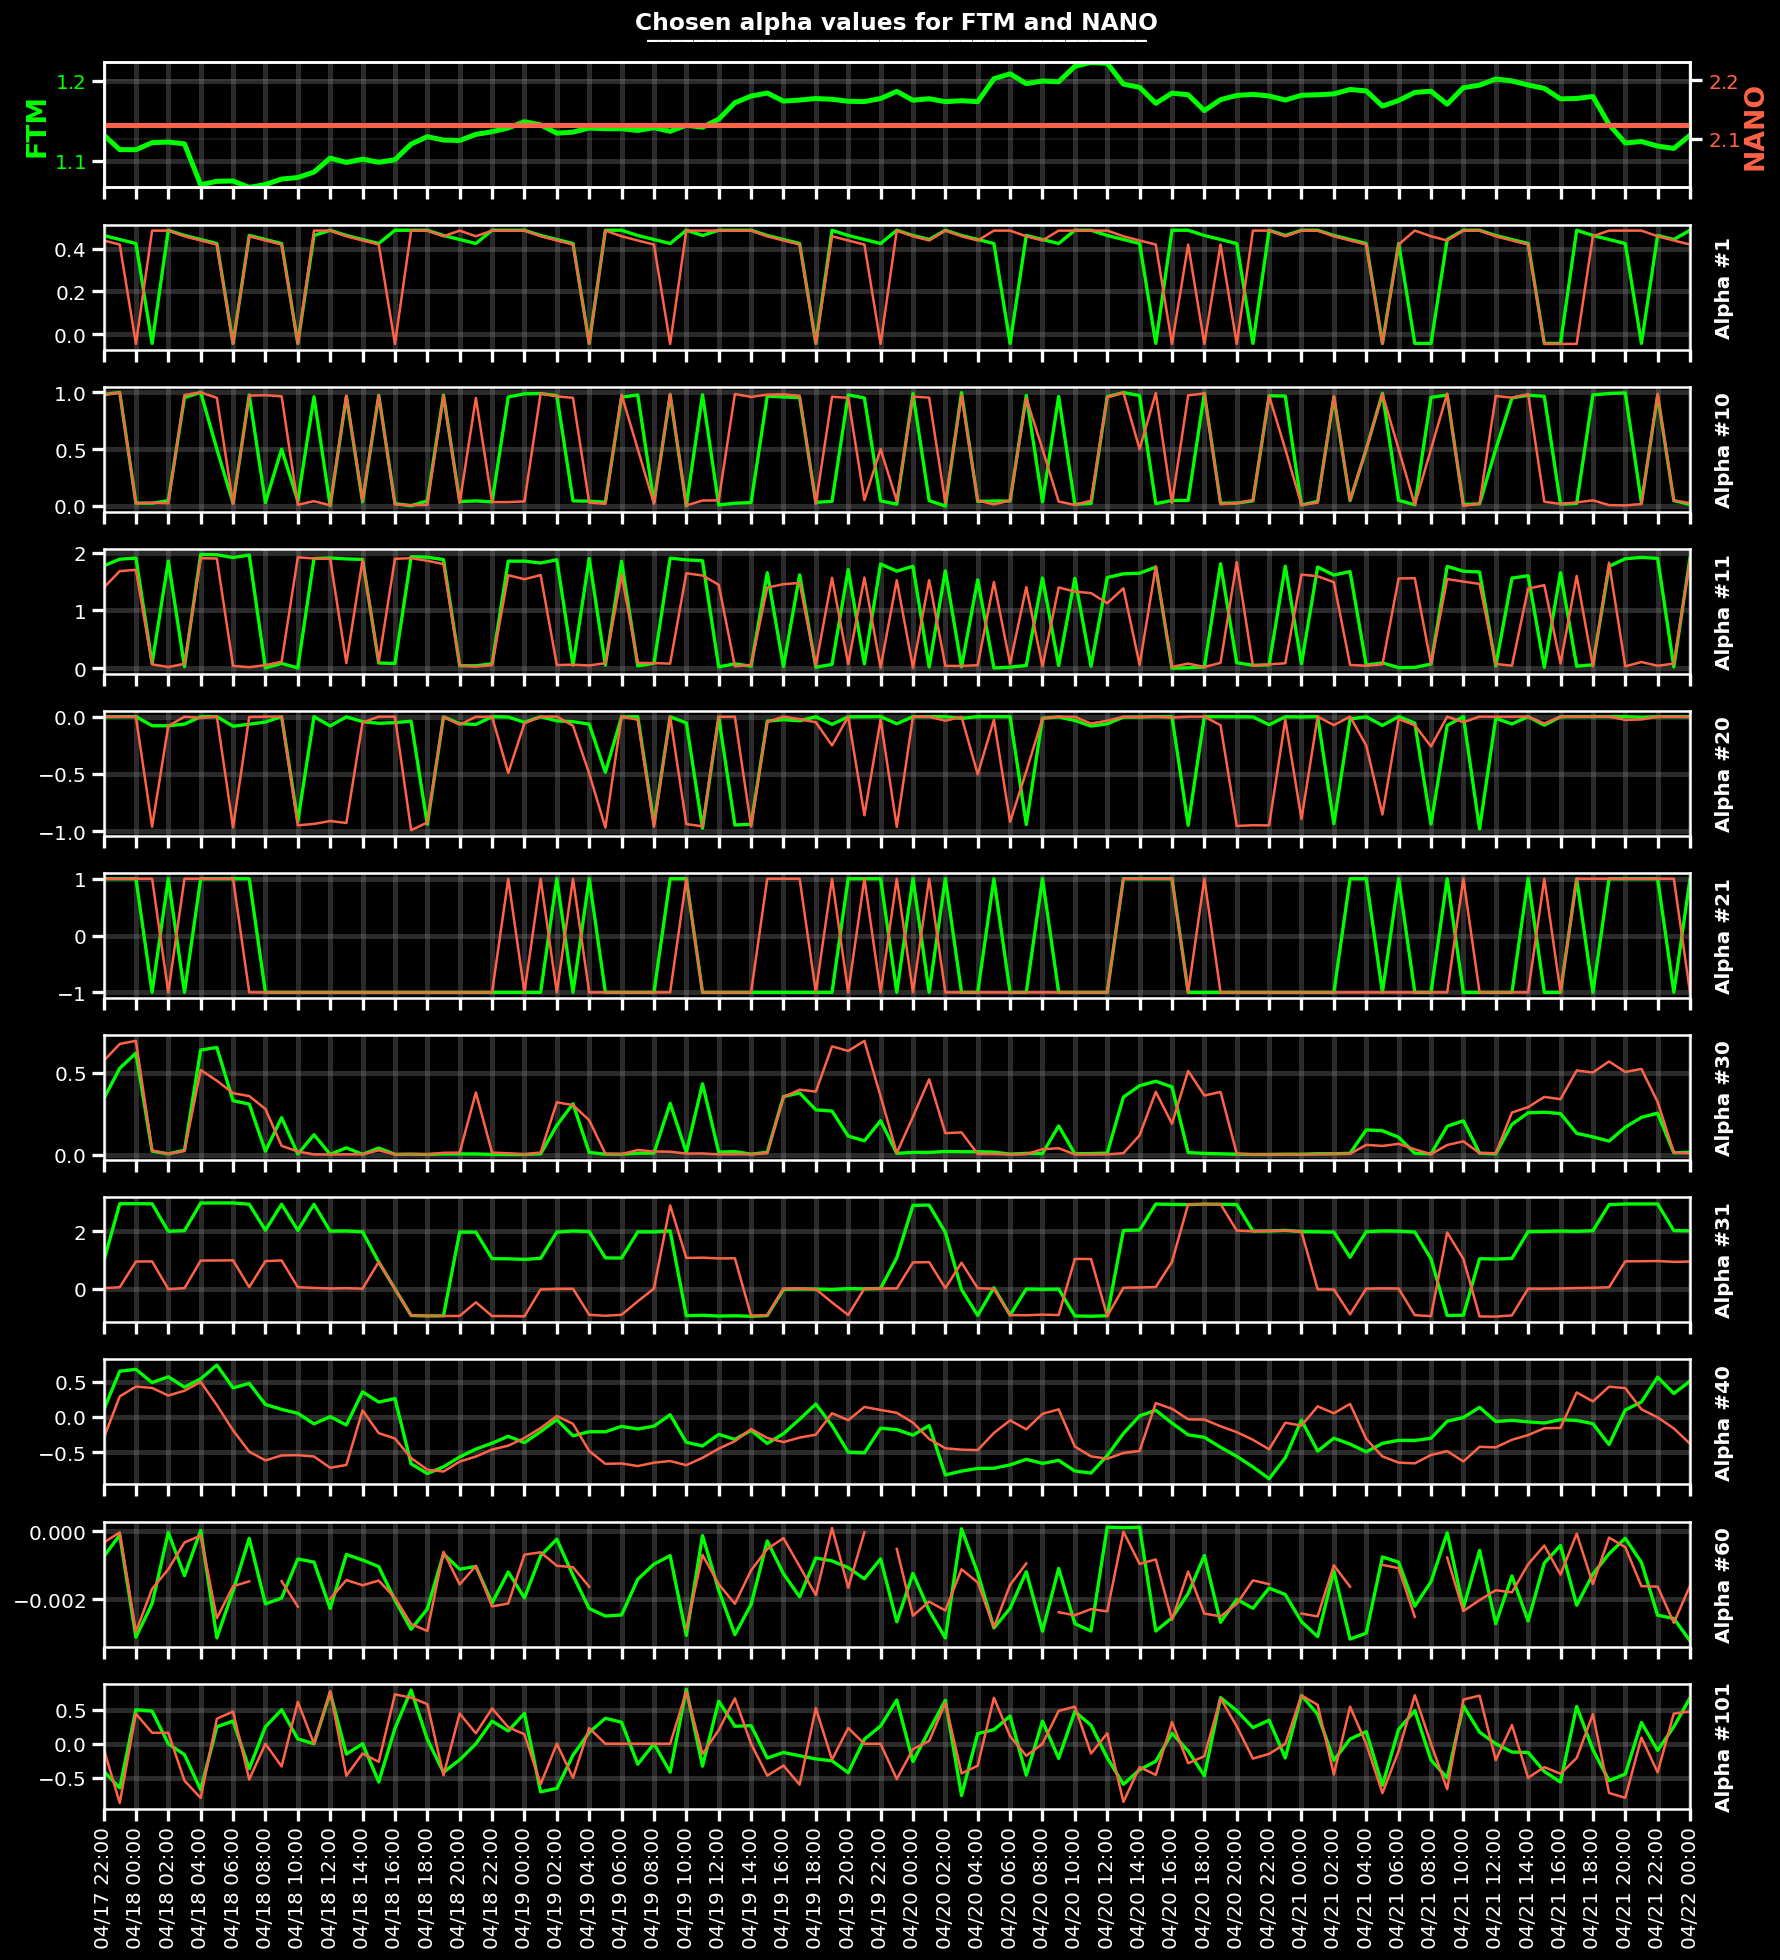

In [5]:
figAlpha = alpha.alphaplot(100)
filename = figAlpha.axes[0].title.get_text()
filename = filename.split("\n")[0]
filepath = "./fig/%s.jpg" % filename
figAlpha.savefig(filepath, dpi = 120)

Among the given 10 alpha models, we could give a use to those that display *non-discrete values* so as to avoid "ties": many instruments with same alpha. For example: "alpha_`21`" can only be `1` or `-1`, so we may have numerous instruments in same categories. Also "alpha_`31`", albeit not entirely discrete, oscilates between 2 somewhat horizontal areas.

A suitable idea would be to use those alphas which seem to be somewhat symmetric, such that may intuitively indicate trend sides: bull or bear. For example: "alpha_`1`", "alpha_`101`", "alpha_`10`" and "alpha_`40`". These are quite shivering though, so a more long-term, "lagging" effect could be added by contributing with a smoother "alpha_`30`". So let those be the "`chosenAlphas`" for the following sections.

<hr>

### Alpha ranking

The set of alphas calculated for each pre-filtered set of top-capped instruments will generate a ranking that may vary monthly, daily or hourly depending on the timeframe that sampled the OHLC data. As provided by past sections, it is taken for granted in the conceptual sense that a positive alpha means a value due to rise, at least in the short term. Therefore, pre-selection shall be done just counting among the largest values of those alphas.

The PDF presented in the intro section regards the construction of certain "**mega-alphas**"; mathematical functions of different, particularly chosen alphas. But the way of doing such task would go beyond the scope of this work. Also, the ones that were coded in the "`Appendix`" file may present different orders of magnitude between each other.

We will use a more naive, straight-forward approach: the next cell shall trace the values of these "`chosenAlphas`" and provide the cryptocurrencies with the "`nRank`" highest values for each alpha. Those "`nKeep`" that appear most frequently, shall have a higher rank overall. The coded method will be discussed below the next cell.

In [6]:
chosenAlphas = [1, 101, 10, 40, 30]
alpha.rank(nKeep = 5, nRank = 1, chosenAlphas = chosenAlphas)
alpha.ranking

[========================================] 100% | Ranking: OK at 2022-04-22, alpha #30    
                                                     

,1,2,3,4,5
time,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN
2021-01-02,IOTA,VTHO,ALGO,AUDIO,TLM
2021-01-03,IOTA,SLP,ALGO,AUDIO,VET
2021-01-04,AUDIO,IOTA,VET,NaN,NaN
2021-01-05,IOTA,SLP,FLUX,KNC,CTSI
...,...,...,...,...,...
2022-04-18,VET,ZIL,ONE,GALA,NaN
2022-04-19,VET,REQ,ZIL,ZRX,NaN
2022-04-20,VET,TLM,FTM,APE,NaN


A brief description and example of the counting/ranking method would be as follows:<br>
Suppose we are choosing the best "`nRank = 3`" instruments out of 2 alphas: "`chosenAlphas = [1, 10]`".<br>
For a certain date "t", ranking from left to right:
* For alpha "`1`": the top 3 are: "`[BTC, ETH, LTC]`". Let's assign "`[3, 2, 1]`" to them, as respective scores.
* For alpha "`10`": the top 3 are: "`[XMR, ETH, DOGE]`".  Assign "`[3, 2, 1]`" to them, as respective scores.
<br>Assigning score "n" to each is the same as repeating each string "n" times, and then counting such:
<br>"`ranked = [BTC, ETH, LTC]`" with "`scores = [3, 2, 1]`" gives: "`repeats = [BTC, BTC, BTC, ETH, ETH, LTC]`".
<br>"`ranked = [XMR, ETH, DOGE]`" with "`scores = [3, 2, 1]`" gives: "`repeats = [XMR, XMR, XMR, ETH, ETH, DOGE]`".

This enables to join multiple different lists of tickers, then counting the word incidence and finding a global score:<br>
"`{"ETH": 4, "XMR": 3, "BTC": 3, "LTC": 1, "DOGE": 1}`". As "`nKeep = 2`", the global top-2 are: `[ETH, XMR]`. <br>
(**Note:** Ties have not been dealt with. They may be avoided if "`nRank`" is made larger.)

The resulting "`.ranking`" `DataFrame` will show the best "`nKeep`" instruments for each day in the "`timeline`" of the downloaded data from Binance. Its last row ("`.iloc[-1]`") will contain "today's" higher-ranked cryptocurrencies. Let's call such row "`alphaTopLast`" and add some info to it in the next cell to the result.

In [7]:
# If ranking managed to find less than "nKeep" instruments...
topRanked = list(alpha.ranking.iloc[-1].dropna()) # ...NaNs can appear.
alphaTopLast = alpha.values.swaplevel(axis = "columns").iloc[-1]
alphaTopLast = alphaTopLast.loc[topRanked].unstack()
alphaTopLast = alphaTopLast[chosenAlphas].round(3)
alphaTopLast.columns = MultiIndex.from_product((["Chosen alphas"], chosenAlphas))
lastColumns = MultiIndex.from_product((["Last data"], columns))
lastValues = marketDF.iloc[-1].unstack()
try: alphaTopLast[lastColumns] = lastValues.loc[alphaTopLast.index]
except: alphaTopLast[lastColumns] = lastValues.transpose().loc[alphaTopLast.index]
print("Top %d instruments:" % alphaTopLast.shape[0], alphaTopLast)

'Top 4 instruments:'

Chosen alphas                             Last data                  \
                1    101     10     40     30     close    high     low   
VET        -0.361  0.000  0.500    NaN -0.055    0.0588  0.0591  0.0588   
OGN        -0.109 -0.739  0.894 -0.034  0.120    0.6026  0.6131  0.6026   
GRT         0.491  0.000  0.017  0.557  0.003    0.3607  0.3623  0.3593   
BAT         0.223  0.125  0.156 -0.819  0.120    0.7556  0.7599  0.7543   

                        
       open     volume  
VET  0.0589  679839.00  
OGN  0.6080   13774.00  
GRT  0.3593   36017.95  
BAT  0.7563    3464.59

**Added feature**

Different days will present different "qualified" instruments. As already seen, the selection algorithm above will just pay attention to the daily filtered instruments. However, it may be interesting to take a brief observation into which do appear more regular in such ranking method, at least during the analyzed period.

We can use some sort of "Gantt-like" graph for that. Each red dot represents that the instrument on the left appeared during the date on the x-axis. Top-most instruments are most frequent, thus could be considered to keep higher overall alphas, and would probably be more frequently traded by us based on this scheme.

The "`.alphaplot2`" function shall return the chart according to what's being held in the global "`.ranking`" `DataFrame` after running "`.rank`". Different parameters applied to the latter method shall return different figures. For example: each vertical line should hold "`nKeep`" dots, representing the amount of preselected instruments per day. A larger "`nKeep`" should therefore return a more densely colored plot.

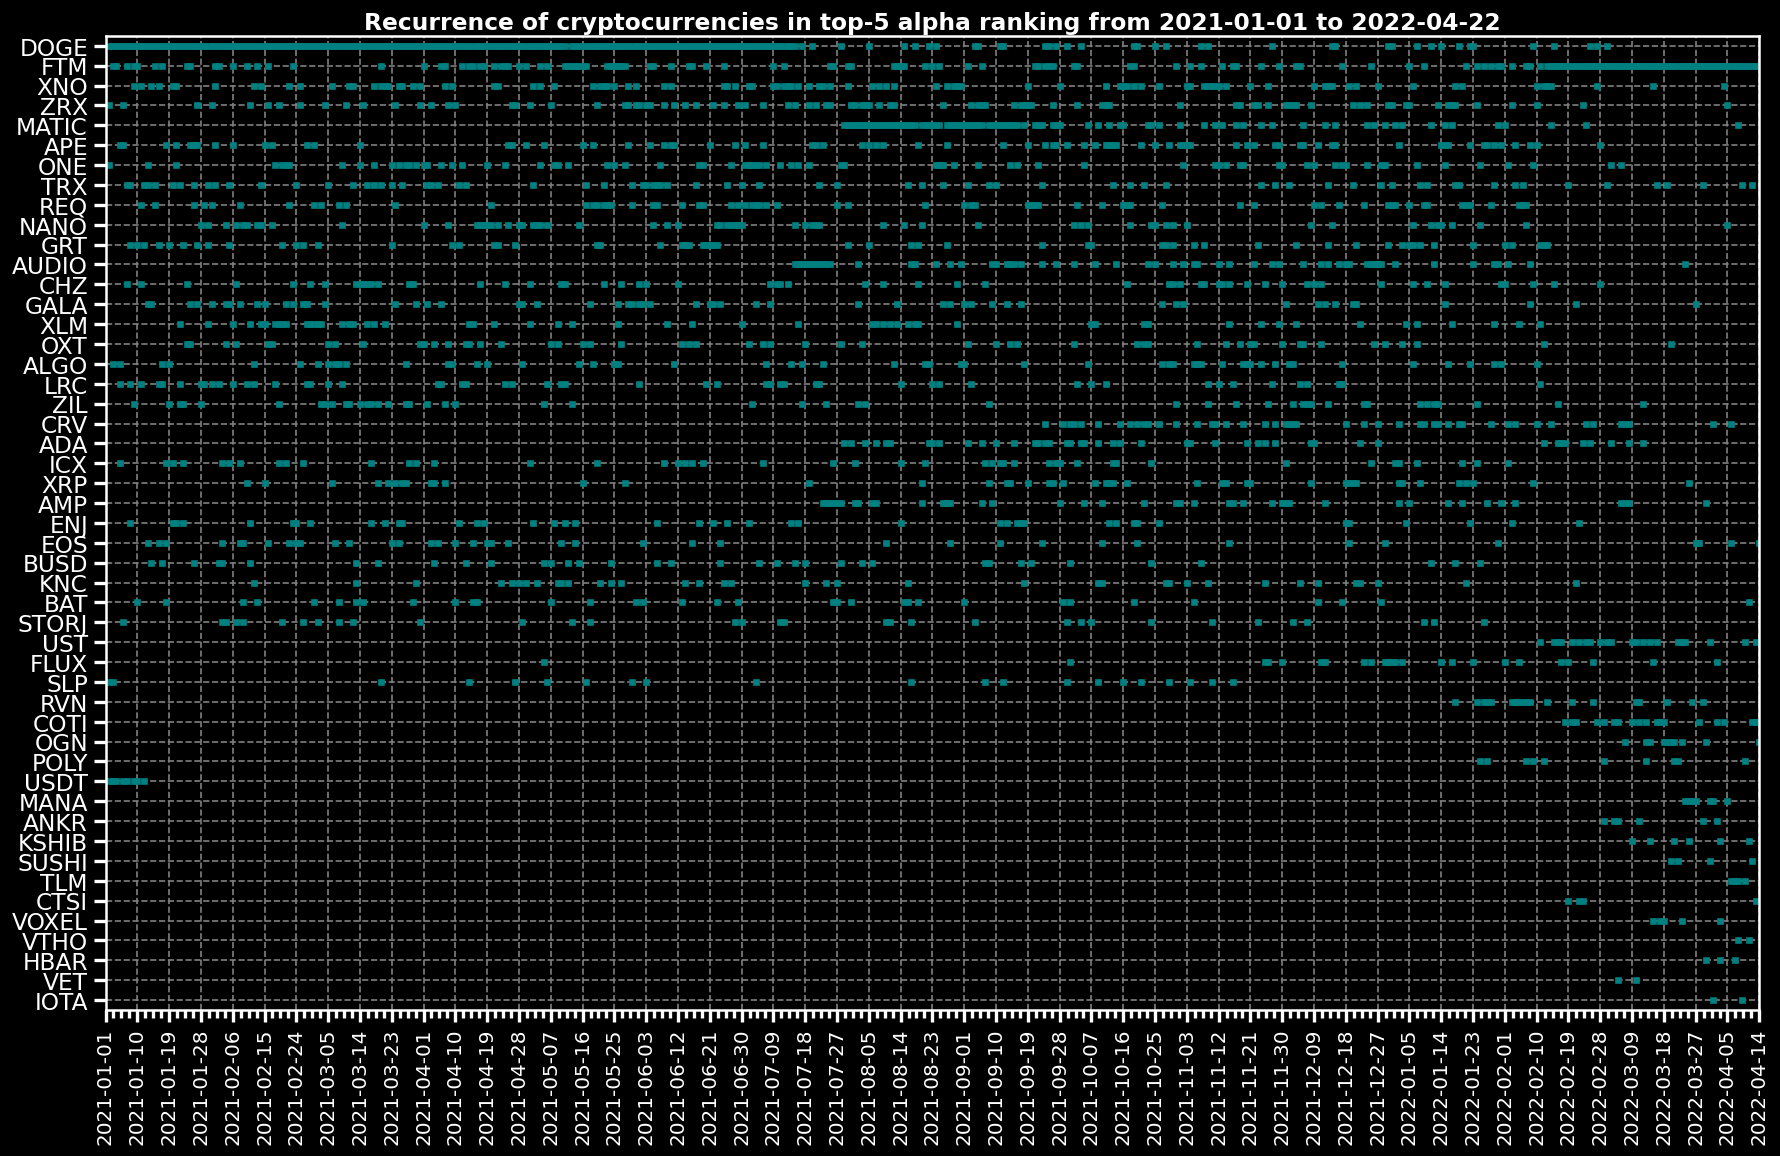

In [8]:
Fig = alpha.alphaplot2(color = "teal")

**We shall continue the rest of the analysis with the instruments found by past sections**, now stored in the `.index` of "`alphaTopValues`". The ranking can be updated or changed according to preferences. A couple of particular configurations that can be further tested:
* "`alpha.rank(nKeep = 1, nRank = `{any}`, chosenAlphas = [`...`])`":<br>
Shall return a single quote which appears the most on all rankings.
* "`alpha.rank(nKeep = 1, nRank = `{any}`, chosenAlphas = [`only one`])`":<br>
Shall return the single daily instrument with the highest value of that only alpha.
* "`alpha.rank(nKeep = `{instrument amount}`, nRank = `any`, chosenAlphas = [`...`])`":<br>
All instruments because we are keeping everyone, not filtering any further. They'll be sorted, though.
Any "`nKeep`" higher than the total amount of instruments should result in an error then, because we cannot select more instruments than those that we already have.

As evident, "`nRank`" does not affect the filtering, but it is the scoring scheme which depend on it. It is however important to note, though, that the larger "`nRank`", the more calculations ("$O(n^2)$"), and therefore more lagging. Refer to the "`.rank`" code in "**Appendix.py**" for further reference.

<hr>

#### Returns and drawdown

A new "`returnDF`" `DataFrame` is built with the same structure as the former "`marketDF`", but with columns specified in "`metrics`" instead of OHLC. Log returns are calculated, because of their additive nature between timestamps. Values will be analyzed later.

In [9]:
marketDF = swap(marketDF, byOHLC = True)
metrics = ["logReturns", "cumReturns", "drawdown"]

quotes = alphaTopLast.index # instruments kept from before
returnDF = DataFrame(numpy.nan, index = marketDF.index,
    columns = MultiIndex.from_product((metrics, quotes)))
returns = marketDF["close"][quotes].pct_change().fillna(0)
returnDF["logReturns"] = numpy.log(1 + returns)
cumLogReturns = returnDF["logReturns"].cumsum() + 1
returnDF["cumReturns"] = numpy.exp(cumLogReturns - 1) - 1
returnDF["drawdown"] = 1 - cumLogReturns / cumLogReturns.cummax()

<hr>

#### Daily resampling

A new "<code>dailyDF</code>" <code>DataFrame</code> is built from compressing the OHLCV data to a daily timeframe. This is done to obtain certain daily / monthly / annual stats later on.

In [10]:
marketDF = swap(marketDF, byOHLC = True)
dailyDF = DataFrame(columns = marketDF.columns)
reframe = {"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"}
for column in columns: dailyDF[column] = marketDF[column].resample("1D").agg(reframe[column])

<hr>

#### Statistics

Finally, "`statDF`" is calculated from past `DataFrame`s. Row indexes are the cryptocurrency labels from Binance, and columns are the different statistics and metrics of interest. They mostly consist of:
* "`upCandles`" and "`dnCandles`": amount of bull and bear candles in original OHLC data.
<br>Reapplied in "`upDays`" and "`dnDays`" but for the daily data resampled above.
* "`retMean`" and "`retStDv`": mean and standard deviation of log returns.
<br>Reapplied in "`retMean_D`" and "`retStDv_D`" but for the daily data resampled above.
<br>When focused on the last 30 days (month), average daily return is labelled "`retMean_D_last`".
* "`retRange`" as the range/amplitude of recorded return values (max - min).
* "`Sharpe`" as the ratio between mean and standard deviation for original and daily data.
<br>For monthly ("...`_M`") and annualized ("...`_Y`") cases, it is calculated as "$S(n) = \sqrt{n}\;S_D$"
<br>Where "$S$" is the daily Sharpe ratio, and "$n$" is the amount of tradeable days considered in each period. <br>Normally, "$n = 20$" monthly, "$n = 252$" yearly. But crypto markets are open 24/7 all year. So: "$n = 30$" and "$n = 365$" respectively.
* "`pNLoss`" is the theoretical probability "$p(x < 0)$" of getting a loss if the individual/daily/monthly/yearly returns were considered to have a Gaussian Normal distribution with probability density function "$N(x)$". In the ideal case in which calculated (sample) mean and standard deviation are equal to their theoretical counterparts "$(\mu, \sigma)$" , then:
$$ p(x < 0) = N(\frac{0 - \mu}{\sigma}) = N(-\frac{\mu}{\sigma}) = N(-S)$$
* "`avgDrawdown`" and "`maxDrawdown`" as the mean and maximum value of the calculated drawdown timeseries.
* "`Calmar`" and "`Sterling`" as "$\mu$/{mean drawdown}" and "$\mu$/{max drawdown}" where "$\mu$" is the average return rate in the original data.

In [11]:
marketDF = swap(marketDF, byOHLC = True)
statDF = DataFrame(index = quotes)
nMonthly, nYearly = 30, 365

statDF["upCandles"] = (marketDF["close"].diff() > 0).sum(axis = "index")
statDF["dnCandles"] = (marketDF["close"].diff() < 0).sum(axis = "index")
statDF["retMean"] = returnDF["logReturns"].mean()
statDF["retStDv"] = returnDF["logReturns"].std()
statDF["Sharpe"] = statDF["retMean"] / statDF["retStDv"]
statDF["pNLoss"] = stats.norm.cdf(-statDF["Sharpe"])
statDF["retRange"] = returnDF["logReturns"].max() - returnDF["logReturns"].min()

statDF["upDays"] = (dailyDF["close"].diff() > 0).sum(axis = "index")
statDF["dnDays"] = (dailyDF["close"].diff() < 0).sum(axis = "index")
statDF["retMean_D"] = dailyDF["close"].pct_change().mean()
statDF["retMean_D_last"] = dailyDF["close"].pct_change().iloc[-30:].mean()
statDF["retStDv_D"] = dailyDF["close"].pct_change().std()

statDF["Sharpe_D"] = statDF["retMean_D"] / statDF["retStDv_D"]
statDF["pNLoss_D"] = stats.norm.cdf(-statDF["Sharpe_D"])
statDF["Sharpe_M"] = numpy.sqrt(nMonthly) * statDF["Sharpe_D"]
statDF["pNLoss_M"] = stats.norm.cdf(-statDF["Sharpe_M"])
statDF["Sharpe_Y"] = numpy.sqrt(nYearly) * statDF["Sharpe_D"]
statDF["pNLoss_Y"] = stats.norm.cdf(-statDF["Sharpe_Y"])

statDF["avgDrawdown"] = returnDF["drawdown"].mean()
statDF["maxDrawdown"] = returnDF["drawdown"].max()
statDF["Calmar"] = statDF["retMean"] / statDF["avgDrawdown"]
statDF["Sterling"] = statDF["retMean"] / statDF["maxDrawdown"]
print("Alpha-filtered instruments' stats:", statDF.transpose())
statDF.transpose().to_csv("./csv/Alpha-filtered instruments' stats.csv")

"Alpha-filtered instruments' stats:"

,VET,OGN,GRT,BAT
upCandles,5529.000000,540.000000,3365.000000,5758.000000
dnCandles,5350.000000,600.000000,3302.000000,5582.000000
retMean,0.000095,0.000057,-0.000046,0.000115
retStDv,0.016982,0.007026,0.010730,0.016125
Sharpe,0.005589,0.008160,-0.004291,0.007140
pNLoss,0.497770,0.496745,0.501712,0.497151
retRange,0.373433,0.384974,0.269952,0.560862
upDays,246.000000,23.000000,137.000000,251.000000
dnDays,224.000000,28.000000,145.000000,225.000000
retMean_D,0.005267,0.002030,-0.000015,0.005528


<hr>

### Portfolio backtest

We shall build a small test cryptocurrency set for the matter, selecting our alpha-preselected cryptocurrencies.

Next step is to allocate position sizes. Aiming towards a stable and balanced portfolio, the amount of investment in each asset should scale to:
* Their *actual price*: {**Cheaper** | **more expensive**} cryptocurrencies should imply a {**larger** | **smaller**} amount of base units (coins) to keep allocation percentage as invariant as possible.
* Their *volatility*: Sharpe is the mean-return-to-volatility ratio, so if all volatilities are scaled up or down to a particular value, returns should be scaled up or down too in the same measure. More volatile positions should therefore be smaller so as to increase global Sharpe ratio.

A starting capital ("`cap`" in USD/cash) should be considered, which will be 100% invested in said selection. We will therefore create a new class "`Portfolio`" to make a simple simulation of how the set would have performed in the past with the downloaded data.

<b>Note:</b> lack of market data from Binance for any cryptocurrency ends up in an horizontal segment in the following graph. That is because "`nan`" values in the "`marketDF`" `DataFrame` generation were filled with (all equal) past close prices and zero volumes.

The following figure would show that the volatility (log) of the net portfolio would be smaller than each one of its components, mostly due to diversification. The intention is: as volatilities are scaled up or down by each allocation size, and therefore "equalized" (almost), the portfolio volatility would be theoretically reduced (divided) by the square root of the amount of components.

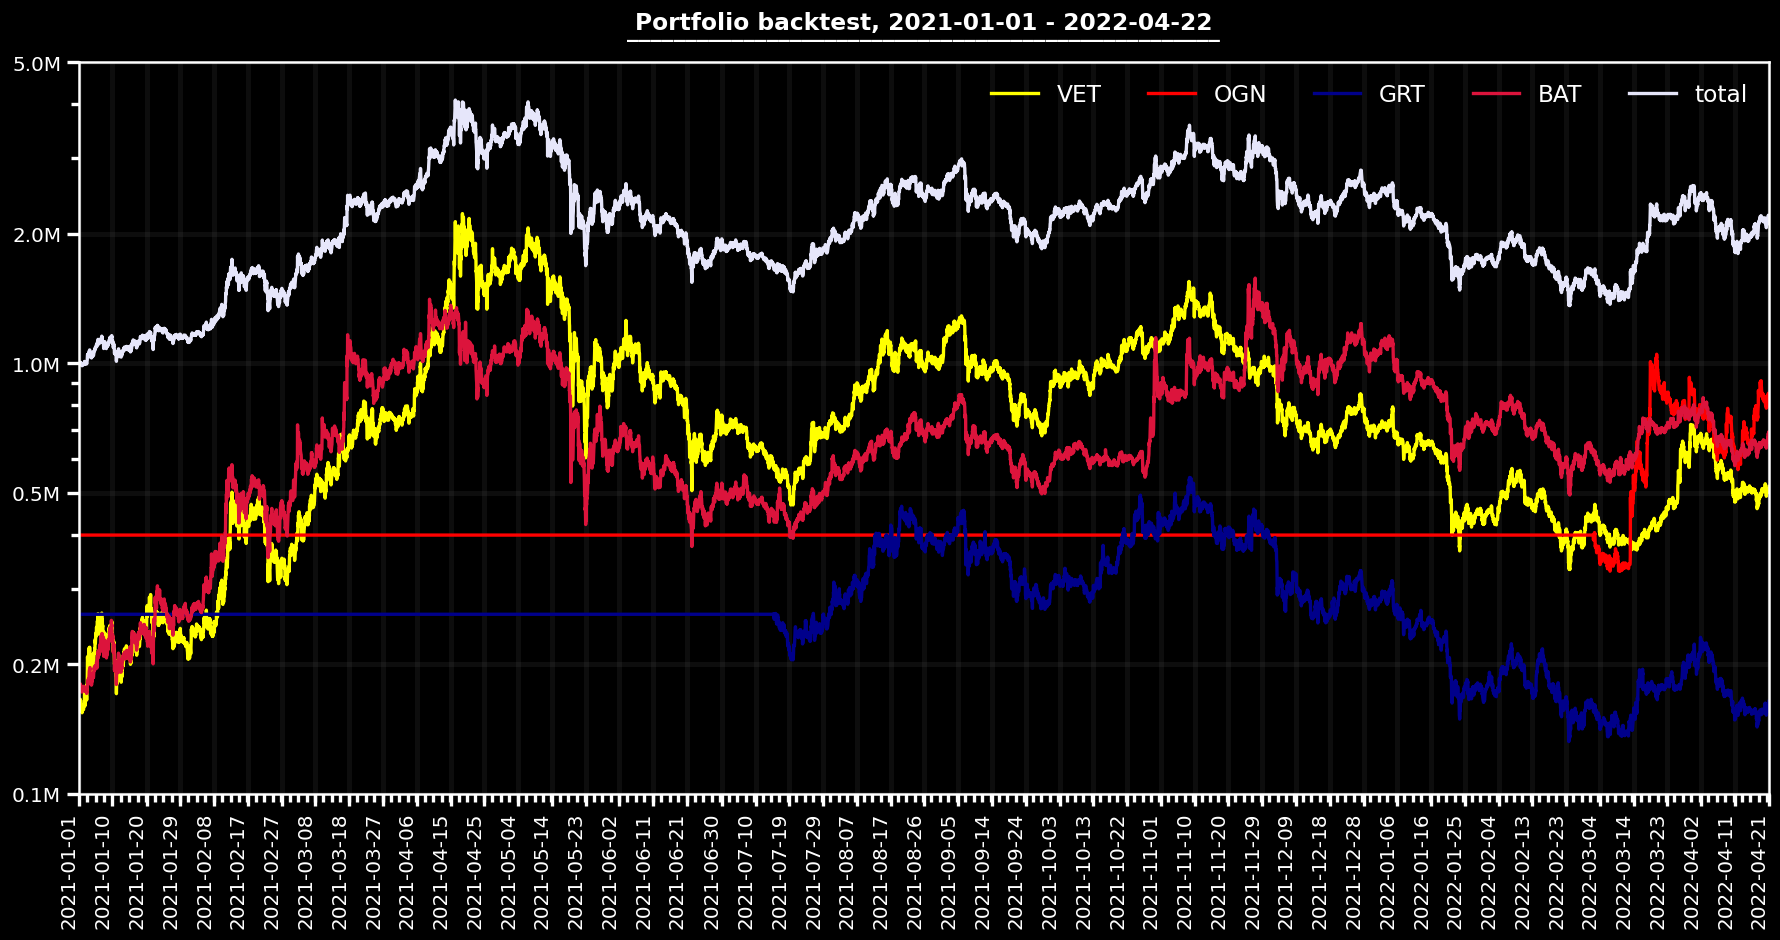

In [12]:
someColors = ["red", "green", "blue", "orange", "yellow", "cyan", "violet", "gold", "lavender",
   "teal", "lime", "darkgreen", "magenta", "pink", "olive", "darkblue", "royalblue", "crimson"]
numpy.random.shuffle(someColors)
plotLabels = list(quotes) + ["total"]
colors = someColors[: len(plotLabels)]

portfolio = Portfolio(1000000, assetLabels = quotes,
        assetLongVols = statDF.loc[quotes, "retStDv"])

returnDF = returnDF.dropna(axis = "index", how = "all")
portfolio.backtest(logReturns = returnDF["logReturns"][quotes])

toPlot = portfolio.btDF[plotLabels].copy()
axes = toPlot.plot(figsize = (15, 8), color = colors, lw = 2)
axes.set_yscale("log")
yLogRange = toPlot.min().min(), toPlot.max().max()
yLogRange = TickRange.log(*yLogRange)
axes.set_yticks(yLogRange)
yTicks = [str(x / 1e6) + "M" for x in yLogRange]
axes.set_yticklabels(yTicks, fontsize = 12)

t1, t2 = returnDF.index[[0, -1]].strftime("%Y-%m-%d")
title = "Portfolio backtest, %s - %s" % (t1, t2)
title += "\n" + "‾" * int(len(title) * 1.2)
axes.set_title(title, fontsize = 14, fontweight = "bold")
axes.tick_params("x", labelsize = 12, rotation = 90)

xTicks = returnDF.index
xTicks = xTicks[:: len(xTicks) // 50]
axes.set_xlim(xTicks[0], xTicks[-1])
axes.grid(True, lw = 3, alpha = 0.1)
axes.set_xticks(xTicks) ; axes.set_xlabel("")
axes.legend(fontsize = 14, ncol = len(plotLabels))
axes.figure.set_tight_layout((0, 0, 1, 1))
axes.figure.savefig("./fig/%s.jpg" % title.split("\n")[0], dpi = 120)

### Future projection

Having all the statistics of said portfolio within reach, then a simple Montecarlo simulation could be generated for a bit longer in the future to have an early idea of how would the portfolio continue performing.

Several random value timeseries would draw an "area" in the chart. Let the worst and the best case be taken into account as the lowest and highest border of such area, respectively.

Highly volatile portfolios with low positive Sharpe ratios would have a positive mean growth (a slightly upward slope), but a wide area. Optimizing the strategy would require to shrink such area and increase the expected curve slope.

**Note:** Watch out for high "`sims`" values, which could lag the execution of the next cell. Notice that the number may not be enough to show consistency. That is: maybe from execution to execution, results (specially the expected profit curve) may vary.

[========================================] 100% | Sim: 100 / 100

C:\DEV\Conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Oreo\AppData\Local\Temp/ipykernel_24032/3255403543.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(yTicks, fontsize = 12)


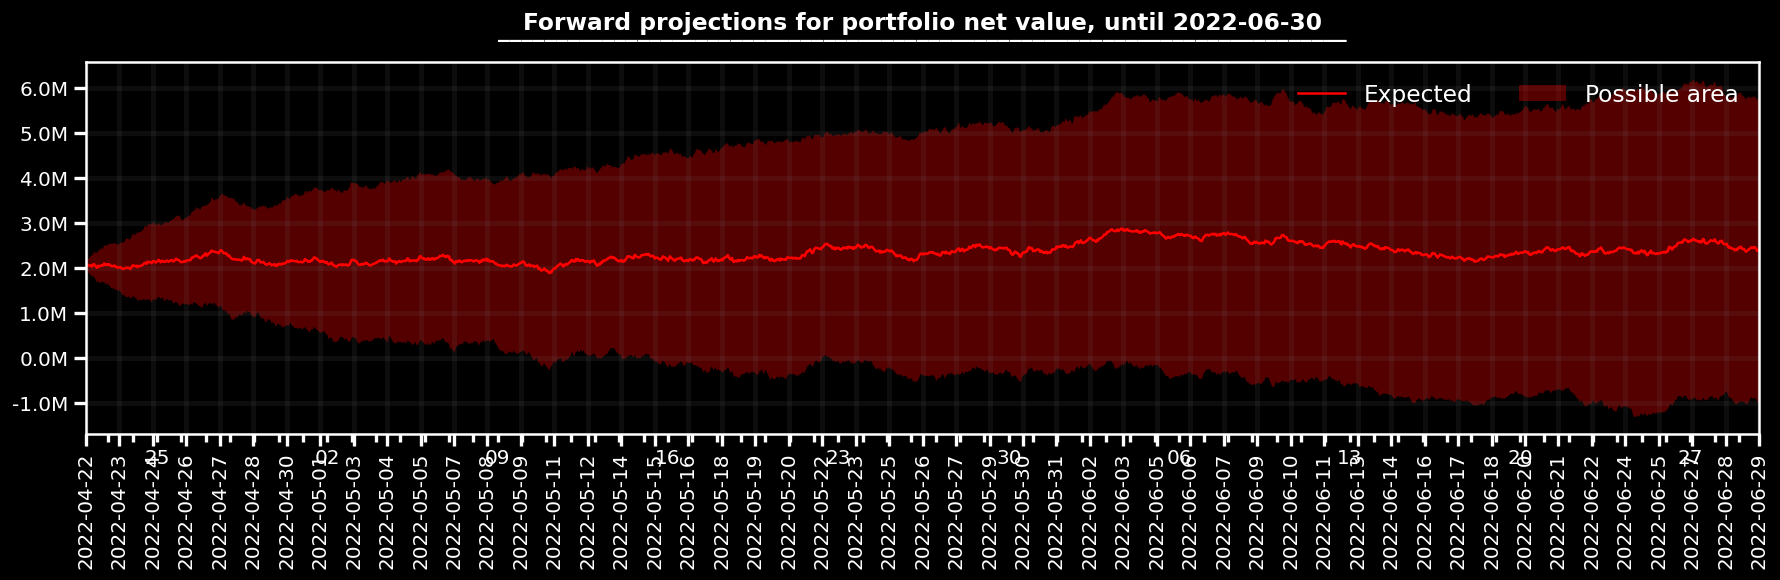

In [13]:
portfolio.forwardtest(until = datetime("2022-07-01"), sims = 100) # sims <= 100

toPlot = concat(portfolio.ftDF, axis = "columns")
toPlot = toPlot.swaplevel(axis = "columns")["total"]
toPlot = toPlot.replace(numpy.inf, numpy.nan)
axes = toPlot["mid"].plot(figsize = (15, 5), label = "Expected")
axes.fill_between(alpha = 1/3, label = "Possible area",
    x = toPlot.index, y1 = toPlot["min"], y2 = toPlot["max"])

yRange = axes.get_yticks()
yTicks = [str(x / 1e6) + "M" for x in yRange]
axes.set_yticklabels(yTicks, fontsize = 12)

t1b = toPlot.index[0].strftime("%Y-%m-%d")
t2b = toPlot.index[-1].strftime("%Y-%m-%d")
title = "Forward projections for "
title += "portfolio net value, until %s" % t2b
title += "\n" + "‾" * int(len(title) * 1.2)
axes.set_title(title, fontsize = 14, fontweight = "bold")
axes.tick_params("x", labelsize = 12, rotation = 90)

xTicks = toPlot.index
xTicks = xTicks[:: len(xTicks) // 50]
axes.set_xlim(xTicks[0], xTicks[-1])
axes.grid(True, lw = 3, alpha = 0.1)
axes.set_xticks(xTicks) ; axes.set_xlabel("")
axes.set_xticklabels(xTicks.strftime("%Y-%m-%d"))
axes.legend(fontsize = 14, ncol = len(quotes) + 1)
axes.figure.set_tight_layout((0, 0, 1, 1))
axes.figure.savefig("./fig/%s.jpg" % title.split("\n")[0], dpi = 120)

We can finally see some stats of the resulting portfolio.

In [14]:
portfolio.stats()
allocation = DataFrame(portfolio.sizes).transpose()
allocation.index = ["USD"]
cap = portfolio.sizes.sum()
allocation.loc["%"] = 100 * allocation.loc["USD"] / cap
print("Portfolio sizes:", allocation.round(2))
print("Portfolio stats:", portfolio.stDF)

'Portfolio sizes:'

,VET,OGN,GRT,BAT
USD,165207.58,399333.45,261472.05,173986.92
%,16.52,39.93,26.15,17.40


'Portfolio stats:'

upCandles      5881.000000
dnCandles      5530.000000
retMean           0.000063
retStDv           0.011140
retRange          0.294488
Sharpe            0.005679
pNLoss            0.497735
retMean_D         0.001514
retStDv_D         0.051843
Sharpe_D          0.029199
pNLoss_D          0.488353
Sharpe_M          0.159928
pNLoss_M          0.288476
Sharpe_Y          0.557842
avgDrawdown       0.200642
maxDrawdown       0.456538
Calmar            0.000315
Sterling          0.000139
dtype: float64